![Failure](https://media1.tenor.com/images/4df194bf79b2b5574248dadfd1cbc61d/tenor.gif?itemid=14856860)

In [1]:
# Plan for tomorrow
# Confirm dataset.
# BC on this, would be legit to use ray to run a separate thread constantly evaling. 
# Multimodal, logloss minimisation. 
# By the end of tomorrow, we should have that working better than MSE on pmO
# Try it on pickyplace
# By thursday, be collecting data, make sure env is deterministically resettable. 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

PLAY = True
PROBS = True
SEQ = True

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

# Load Data

In [2]:
# Discrete Examples 
discrete = "collected_data/17100experiment_2_HER_pointMassObject-v0.npz"

# Continuos play
play = "collected_data/17000_play_pointMassObject-v0.npz"

# Play with pauses
#play = "collected_data/17000experiment_2_HER_pointMassObject-v0.npz"

if PLAY:
    data = np.load(play)
else:
    data = np.load(discrete)
    
train_partition = 0.8
N_TRAJS = len(data['obs'])
TRAJ_LEN = len(data['obs'][0])
train_data = {key:value[:int(N_TRAJS*train_partition)] for key, value in data.items()}
valid_data = {key:value[int(N_TRAJS*train_partition):] for key, value in data.items()}
# Data comes out as n_trajs, length_of_traj, dimension.

def get_discrete_batch(data, batch_size = 64):
    obs, goals, acts = data['obs'], data['desired_goals'], data['acts']
    n_trajs, len_trajs = obs.shape[0], obs.shape[1]
    traj_idxs = np.random.choice(n_trajs, batch_size)
    timestep_idxs = np.random.choice(len_trajs, batch_size)
    batch_obs = obs[traj_idxs,timestep_idxs,:]
    batch_goals = goals[traj_idxs,timestep_idxs,:]
    batch_acts  = acts[traj_idxs,timestep_idxs,:]
    return batch_obs, batch_goals, batch_acts
    
# Play Examples
# TBC

# Okay in this function steps will be
# choose random start index, choose random end_index within certain window
# end of trajectory achieved goal is goal. 
# i.e, choose random index, choose random index from 1 - maxlen clip at end.
# that ag is goal. 
# return, yay!
def get_play_batch(data, batch_size = 64, max_ep_len = 100):
    obs, ags, acts = data['obs'], data['achieved_goals'], data['acts']
    n_trajs, len_trajs = obs.shape[0], obs.shape[1]
    traj_idxs = np.random.choice(n_trajs, batch_size)
    timestep_idxs = np.random.choice(len_trajs, batch_size)
    goal_offset = np.random.randint(0, max_ep_len, batch_size)
    goal_idxs = np.clip(timestep_idxs + goal_offset, 0, len_trajs-1)
    batch_obs = obs[traj_idxs,timestep_idxs,:]
    batch_goals = ags[traj_idxs,goal_idxs,:]
    batch_acts  = acts[traj_idxs,timestep_idxs,:]
    return batch_obs, batch_goals, batch_acts

def get_play_sequence_batch(data, batch_size=64, max_ep_len=100, seq_len = 15):
    
    obs, ags, acts = data['obs'], data['achieved_goals'], data['acts']
    n_trajs, len_trajs = obs.shape[0], obs.shape[1]
    traj_idxs = np.random.choice(n_trajs, batch_size)
    # First timestep
    timestep_idxs = np.random.choice(len_trajs-seq_len, batch_size)
    # Goal Pos
    goal_offset = np.random.randint(seq_len, max_ep_len, batch_size)
    goal_idxs = np.clip(timestep_idxs + goal_offset, 0, len_trajs-1)

    trajectories_obs = []
    trajectories_goals = []
    trajectories_acts = []
    for i in range(0, batch_size):

        batch_obs = trajectories_obs.append(obs[traj_idxs[i],timestep_idxs[i]:timestep_idxs[i]+seq_len,:])
        batch_acts = trajectories_acts.append(acts[traj_idxs[i],timestep_idxs[i]:timestep_idxs[i]+seq_len,:])
        batch_goals = trajectories_goals.append(ags[traj_idxs[i],goal_idxs[i],:])

    return np.array(trajectories_obs), np.tile(np.expand_dims(np.array(trajectories_goals), axis = 1), (seq_len, 1)), np.array(trajectories_acts)
    

    
if PLAY:
    if SEQ:
        get_batch = get_play_sequence_batch
    else:
        get_batch = get_play_batch
else:
    get_batch = get_discrete_batch
# Play, but with Sequences

# Get Environment Params

In [3]:
act_dim = train_data['acts'].shape[-1]

# Models

In [4]:

class deterministic_MLP(tf.keras.Model):

    def __init__(self, act_dim, layer_size = 256):
        super(deterministic_MLP, self).__init__()
        self.dense1 = tf.keras.layers.Dense(layer_size, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(layer_size, activation=tf.nn.relu)
        self.dense3 = tf.keras.layers.Dense(layer_size, activation=tf.nn.relu)
        self.out = tf.keras.layers.Dense(act_dim, activation=None)

    def call(self, inputs, training=False):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        return self.out(x)
    
    def act(self, inputs):
        return self.call(inputs)
    
class stochastic_MLP(tf.keras.Model):

    def __init__(self, act_dim, num_distribs = 3, layer_size = 256):
        super(stochastic_MLP, self).__init__()
        self.num_distribs = num_distribs
        self.act_dim = act_dim
        self.dense1 = tf.keras.layers.Dense(layer_size, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(layer_size, activation=tf.nn.relu)
        self.dense3 = tf.keras.layers.Dense(layer_size, activation=tf.nn.relu)
        self.mu = tf.keras.layers.Dense(act_dim*num_distribs, activation=None)
        self.scale = tf.keras.layers.Dense(act_dim*num_distribs, activation="softplus")
        self.weightings = tf.keras.layers.Dense(act_dim*num_distribs, activation="softplus")

    def call(self, inputs, training=False):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        mu, scale, weightings = self.mu(x), self.scale(x), self.weightings(x)
        mu, scale, weightings = tf.reshape(mu, (-1, self.act_dim, self.num_distribs)), tf.reshape(scale, (-1, self.act_dim, self.num_distribs)), tf.reshape(weightings, (-1, self.act_dim, self.num_distribs))
        dist = tfd.Logistic(loc=mu, scale=scale)
        
        mixture = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(
                          probs=weightings),components_distribution=dist)
        
        return mixture
    
    def act(self, inputs):
        return self.call(inputs).sample()
    
    
class LSTM(tf.keras.Model):

    def __init__(self, act_dim, num_distribs = 3, layer_size = 512):
        super(LSTM, self).__init__()
        self.num_distribs = num_distribs
        self.act_dim = act_dim


        self.RNN1 = tf.keras.layers.LSTM(layer_size, return_sequences=True, return_state = True)
        self.RNN2 = tf.keras.layers.LSTM(layer_size, return_sequences=True, return_state = True)
        self.mu = tf.keras.layers.Dense(act_dim*num_distribs, activation=None)
        self.scale = tf.keras.layers.Dense(act_dim*num_distribs, activation="softplus")
        self.weightings = tf.keras.layers.Dense(act_dim*num_distribs, activation="softplus")

    def call(self, inputs, training=False, past_state = None):
        B = inputs.shape[0]
        state_out = None
        if len(inputs.shape) == 3:
            [x, _, _] = self.RNN1(inputs)
            [x, _, _] = self.RNN2(x)
        else:
            x = tf.expand_dims(inputs,1)
            [x, s1l1, s2l1] = self.RNN1(x, initial_state = past_state[0])
            [x, s1l2, s2l2] = self.RNN2(x, initial_state = past_state[1])
            state_out = [[s1l1, s2l1], [s1l2, s2l2]]
            

        mu, scale, weightings = self.mu(x), self.scale(x), self.weightings(x)
        mu, scale, weightings = tf.reshape(mu, (B, -1, self.act_dim, self.num_distribs)), tf.reshape(scale, (B, -1, self.act_dim, self.num_distribs)), tf.reshape(weightings, (B, -1, self.act_dim, self.num_distribs))
        dist = tfd.Logistic(loc=mu, scale=scale)
        
        mixture = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(
                          probs=weightings),components_distribution=dist)
        if state_out is None:
            return mixture
        else:
            return mixture, state_out
    

# Steps

In [5]:
def step(data, model):
    obs, goals, acts = get_batch(data)
    mu = model(np.concatenate([obs, goals], axis = -1))
    loss = tf.reduce_mean(tf.losses.MSE(mu, acts))
    return loss

def probabilistic_step(data, model):
    obs, goals, acts = get_batch(data)
    mixture = model(np.concatenate([obs, goals], axis = -1))
    
    loss = -tf.reduce_mean(mixture.log_prob(acts))
    return loss
    
def train_step(data, model, optimizer):
    with tf.GradientTape() as tape:
        loss = step(data, model)
        
    variables = model.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return loss.numpy()
        

# Setup

In [16]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

if PROBS:
    step = probabilistic_step
    if SEQ:
        model = LSTM(act_dim = act_dim)
    else:
        model = stochastic_MLP(act_dim = act_dim)
else:
    model = deterministic_MLP(act_dim=act_dim)


# Loop

Step: 0, L: 1.1364253759384155, Valid_L: 1.1366771459579468
Step: 200, L: 0.22554516792297363, Valid_L: 0.4748828113079071
Step: 400, L: -0.026457078754901886, Valid_L: 0.222161665558815
Step: 600, L: -0.2994925379753113, Valid_L: 0.017208149656653404
Step: 800, L: -0.1891903430223465, Valid_L: -0.003575362730771303
Step: 1000, L: -0.21652261912822723, Valid_L: 0.20628799498081207
Step: 1200, L: -0.6795368790626526, Valid_L: 0.14213399589061737
Step: 1400, L: -0.49135762453079224, Valid_L: -0.14181114733219147
Step: 1600, L: -0.6359795928001404, Valid_L: 1.2843456268310547
Step: 1800, L: -0.7016018629074097, Valid_L: -0.0018316437490284443
Step: 2000, L: -0.7234991192817688, Valid_L: -0.42496880888938904
Step: 2200, L: -0.8760562539100647, Valid_L: 0.015096819028258324
Step: 2400, L: -0.7774268388748169, Valid_L: -0.10730941593647003
Step: 2600, L: -0.782111406326294, Valid_L: 0.13216453790664673
Step: 2800, L: -1.0292106866836548, Valid_L: -0.22741419076919556
Step: 3000, L: -1.014551

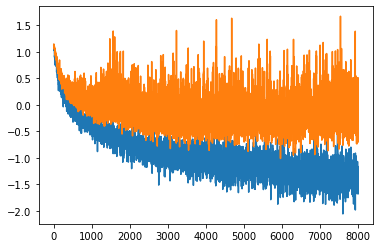

In [17]:
n_steps = 8000
t = 0
steps = []
losses = []
valid_losses = []

# TODO RAY async trajectories in background
for t in range(0, n_steps):
    loss = train_step(train_data, model, optimizer)
    steps.append(t)
    losses.append(loss)
    valid_loss = step(valid_data, model)
    valid_losses.append(valid_loss)
    
    if t % 200 == 0:
        print(f"Step: {t}, L: {loss}, Valid_L: {valid_loss}")
    
    
plt.plot(steps, losses)
plt.plot(steps, valid_losses)

In [12]:
import gym
import pointMass

env_name = 'pointMassObject-v0' 
env = gym.make(env_name)
env.render(mode='human')
env.reset()


seeding
Environment set to sparse reward


/home/sholto/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


{'observation': array([0.9222576 , 1.0042969 , 0.        , 0.        , 0.4076209 ,
        0.47690952, 0.        , 0.        ], dtype=float32),
 'achieved_goal': array([0.4076209 , 0.47690952], dtype=float32),
 'desired_goal': array([ 0.59002477, -1.1817743 ], dtype=float32),
 'extra_info': array([0.4, 0. , 0. , 0. , 1. ], dtype=float32),
 'controllable_achieved_goal': array([0.9222576, 1.0042969], dtype=float32),
 'full_positional_state': array([0.9222576 , 1.0042969 , 0.4076209 , 0.47690952], dtype=float32),
 'image': array([[[236, 236, 236],
         [234, 234, 234],
         [232, 232, 232],
         ...,
         [197, 197, 197],
         [227, 227, 227],
         [227, 227, 227]],
 
        [[235, 235, 235],
         [233, 233, 233],
         [232, 232, 232],
         ...,
         [197, 197, 197],
         [197, 197, 197],
         [197, 197, 197]],
 
        [[235, 235, 235],
         [233, 233, 233],
         [232, 232, 232],
         ...,
         [197, 197, 197],
         [1

In [53]:
%matplotlib notebook

from celluloid import Camera

def trajectory(env, actor, n_steps = 300):
    obs = env.reset()
    reward = 0
    for t in range(0, n_steps):
        flattened_obs  = np.expand_dims(np.concatenate((obs['observation'], obs['desired_goal'])), axis = 0)
        a = actor(flattened_obs).numpy().squeeze()
        obs, r, d, _  =  env.step(a)
        reward += r
    return reward
    

    
def trajectory_LSTM(env, actor, n_steps = 200):
    obs = env.reset()
    reward = 0
    past_state = [None, None]
    camera = Camera(plt.figure())
    
    for t in range(0, n_steps):
        flattened_obs  = np.expand_dims(np.concatenate((obs['observation'], obs['desired_goal'])), axis = 0)
        distrib, past_state = actor(flattened_obs, past_state = past_state)
        clear_output(wait=True)
        plot_distrib(distrib[0][0][0])
        
        camera.snap()
        #plot_distrib(distrib[0][0][1])
        
        a = distrib.sample().numpy().squeeze() 
        obs, r, d, _  =  env.step(a)
        reward += r
    anim = camera.animate(blit=True)
    return reward
    


<IPython.core.display.Javascript object>


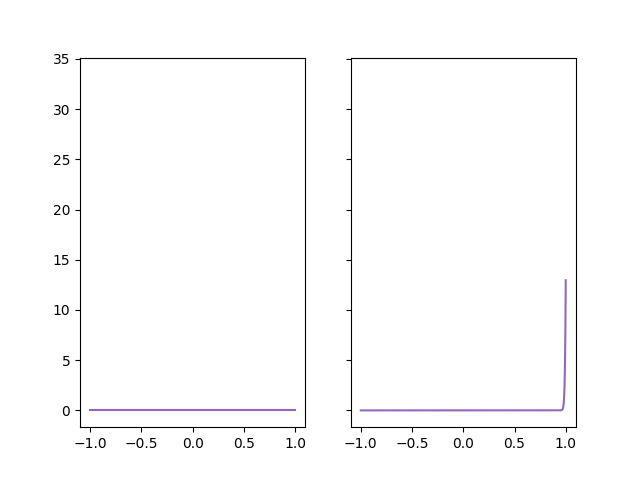

In [67]:
obs = env.reset()
actor = model
reward = 0



def plot_distrib(distrib,ax):
    x = np.linspace(-1., 1., int(1e3), dtype=np.float32)
    ax.plot(x, distrib.prob(x));
    
past_state = [None, None]
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
camera = Camera(f)

for t in range(0, 150):
    flattened_obs  = np.expand_dims(np.concatenate((obs['observation'], obs['desired_goal'])), axis = 0)
    distrib, past_state = actor(flattened_obs, past_state = past_state)
    plot_distrib(distrib[0][0][0], ax1)
    plot_distrib(distrib[0][0][1], ax2)
    camera.snap()
    

    a = distrib.sample().numpy().squeeze() 
    obs, r, d, _  =  env.step(a)
    reward += r
anim = camera.animate(blit=True)

In [59]:
anim.save('scatter.mp4')

<IPython.core.display.Javascript object>


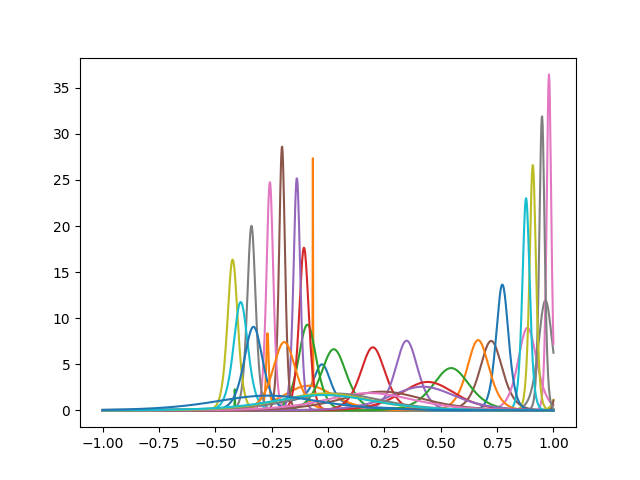

KeyboardInterrupt: 

In [45]:
rews = []
for i in range(0,10):
    r = trajectory_LSTM(env, model)
    rews.append(r)
    
print(f"Avg reward: {np.mean(rews)}")

In [111]:
rews = []
for i in range(0,10):
    r = trajectory(env, model.act)
    rews.append(r)
    
print(f"Avg reward: {np.mean(rews)}")

Avg reward: -300.0


In [12]:
# Visualising Plans

    

-0.99469244

<IPython.core.display.Javascript object>


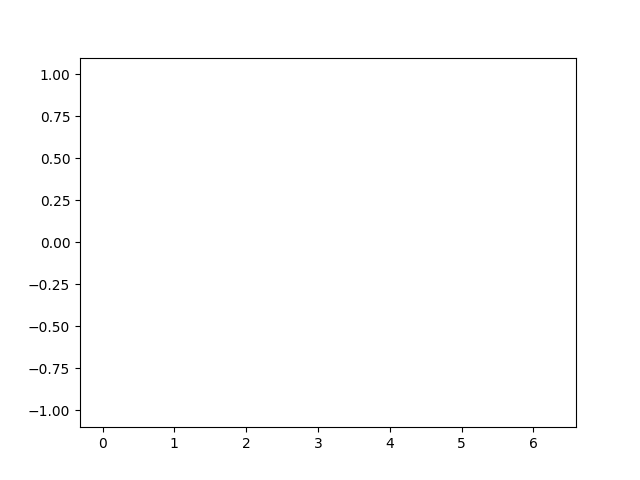

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, ax = plt.subplots()

x = np.arange(0, 2*np.pi, 0.01)
line, = ax.plot(x, np.sin(x))



def init():  # only required for blitting to give a clean slate.
    line.set_ydata([np.nan] * len(x))
    return line,


obs = env.reset()
reward = 0
past_state = [None, None]


def animate(i):
    flattened_obs  = np.expand_dims(np.concatenate((obs['observation'], obs['desired_goal'])), axis = 0)
    distrib, past_state = actor(flattened_obs, past_state = past_state)
    line.set_ydata(np.sin(x + i / 100))  # update the data.
    a = distrib.sample().numpy().squeeze() 
    obs, r, d, _  =  env.step(a)
    return line,


ani = animation.FuncAnimation(
    fig, animate, init_func=init, interval=2, blit=True, save_count=50)

plt.show()

In [23]:
r = trajectory(env, model)

Text(0, 0.5, 'probability density function')

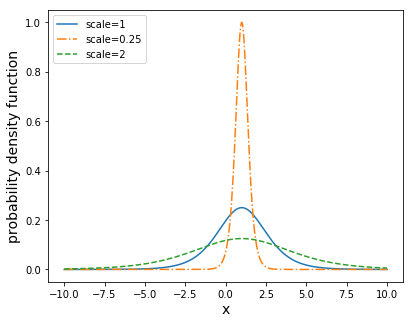

In [7]:
plt.figure(figsize=(14,5))

vals = np.linspace(-10,10,1000) 

plt.subplot(1,2,1)
dist1 = tfd.Logistic(loc=1, scale=1)
dist2 = tfd.Logistic(loc=1, scale=0.25)
dist3 = tfd.Logistic(loc=1, scale=2)

plt.plot(vals, dist1.prob(vals)) 
plt.plot(vals, dist2.prob(vals),ls='-.') 
plt.plot(vals, dist3.prob(vals),ls='--') 
plt.legend(['scale=1', 'scale=0.25','scale=2'], loc='upper left')
plt.xlabel('x',fontsize=14)
plt.ylabel('probability density function',fontsize=14)

In [8]:
print(dist1.sample(10))
print(dist2.sample(10))
print(dist3.sample(10))

tf.Tensor(
[ 0.48355418 -1.2014077   2.056894    1.1037507  -1.8138905   2.0407314
  2.0601716  -2.2348516   2.9733465  -5.077167  ], shape=(10,), dtype=float32)
tf.Tensor(
[0.91136014 0.90255976 0.9090593  1.0292451  1.8690107  1.5355909
 1.1911904  0.17218739 0.79381096 0.48775065], shape=(10,), dtype=float32)
tf.Tensor(
[ 1.7996119   2.6687827   3.750018    7.722861   -6.0115094  -0.24049318
  0.306206    1.5157307   0.96929777  0.96143985], shape=(10,), dtype=float32)


<StemContainer object of 3 artists>

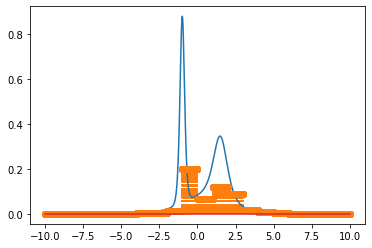

In [8]:
weightings = [1,1,1]
dist = tfd.Logistic(loc=[-1, 0.6, 1.5], scale=[0.1, 1, 0.3])
mixture_cts = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(
                  probs=weightings),components_distribution=dist)

n_quantizations = 256
quantized = tfd.QuantizedDistribution(dist,low=-n_quantizations/2, high=n_quantizations/2)
mixture_discrete = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(
                  probs=weightings),components_distribution=quantized)

# Plot PDF.
x = np.linspace(-10., 10, int(1e4), dtype=np.float32)
import matplotlib.pyplot as plt
plt.plot(x, mixture_cts.prob(x));
plt.stem(x, mixture_discrete.prob(x), use_line_collection=True, markerfmt='C1o',linefmt='C1-.') 

In [25]:
import sys
!{sys.executable} -m pip install --upgrade matplotlib

    100% |████████████████████████████████| 12.4MB 1.3MB/s ta 0:00:01
spinup 0.1.2 has requirement cloudpickle==0.5.2, but you'll have cloudpickle 1.2.2 which is incompatible.
spinup 0.1.2 has requirement matplotlib==3.0.2, but you'll have matplotlib 3.2.2 which is incompatible.
spinup 0.1.2 has requirement seaborn==0.8.1, but you'll have seaborn 0.9.0 which is incompatible.
spinup 0.1.2 has requirement tensorflow<2.0,>=1.8.0, but you'll have tensorflow 2.1.0 which is incompatible.
  Found existing installation: matplotlib 3.0.3
    Uninstalling matplotlib-3.0.3:
      Successfully uninstalled matplotlib-3.0.3


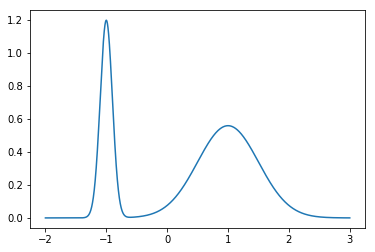

In [26]:

gm = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(
        probs=[0.3, 0.7]),
    components_distribution=tfd.Normal(
      loc=[-1., 1],       # One for each component.
      scale=[0.1, 0.5]))  # And same here.

gm.mean()
# ==> 0.4

gm.variance()
# ==> 1.018

# Plot PDF.
x = np.linspace(-2., 3., int(1e4), dtype=np.float32)
import matplotlib.pyplot as plt
plt.plot(x, gm.prob(x));